In [48]:
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.8.2


# Saving and loading models

 ## Coding tutorials
 #### [1. Saving and loading model weights](#coding_tutorial_1)
 #### [2. Model saving criteria](#coding_tutorial_2)
 #### [3. Saving the entire model](#coding_tutorial_3)
 #### [4. Loading pre-trained Keras models](#coding_tutorial_4)
 #### [5. Tensorflow Hub modules](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Saving and loading model weights

#### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. For an introduction and a download, see [this link](https://www.cs.toronto.edu/~kriz/cifar.html).

In [49]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [50]:
x_train.shape


(10000, 32, 32, 3)

In [51]:
# fig, ax = plt.subplots(1, 10, figsize=(25,10))

# for i in range(10):
#     ax[i].set_axis_off()
#     ax[i].imshow(x_train[i,])


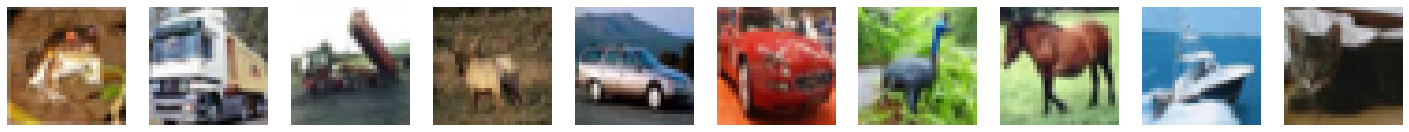

In [52]:
# Plot the first 10 CIFAR-10 images

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 10, figsize=(25, 10))
for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(x_train[i])

#### Introduce two useful functions

In [53]:
# Introduce function to test model accuracy

def get_test_accuracy(model, x_test, y_test):
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [54]:
# Introduce function that creates a new instance of a simple CNN

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3), 
               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Create simple convolutional neural network classifier

In [55]:
# Create an instance of the model and show model summary
model = get_new_model()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 8)         1160      
                                                                 
 pool_1 (MaxPooling2D)       (None, 7, 7, 8)           0         
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                12576     
                                                                 
 dense_2 (Dense)             (None, 10)                330       
                                                                 
Total params: 14,514
Trainable params: 14,514
Non-trai

In [56]:
# Test accuracy of the untrained model, around 10% (random)
get_test_accuracy(model, x_test, y_test)


accuracy: 0.093


#### Train model with checkpoints

In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [58]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints/my_model'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             frequency='epoch',
                             save_weights_only=True,
                             verbose=1)


In [59]:
from gc import callbacks
# Fit model, with simple checkpoint which saves (and overwrites) model weights every epoch

history = model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint])


Epoch 1/3
304/313 [============================>.] - ETA: 0s - loss: 2.0133 - accuracy: 0.2627
Epoch 1: saving model to model_checkpoints/my_model
313/313 [==============================] - 3s 4ms/step - loss: 2.0068 - accuracy: 0.2656
Epoch 2/3
311/313 [============================>.] - ETA: 0s - loss: 1.6454 - accuracy: 0.4074
Epoch 2: saving model to model_checkpoints/my_model
313/313 [==============================] - 1s 3ms/step - loss: 1.6453 - accuracy: 0.4078
Epoch 3/3
311/313 [============================>.] - ETA: 0s - loss: 1.5273 - accuracy: 0.4498
Epoch 3: saving model to model_checkpoints/my_model
313/313 [==============================] - 1s 3ms/step - loss: 1.5269 - accuracy: 0.4496


In [60]:
# Have a look at what the checkpoint creates
!ls -lh
!ls -lh model_checkpoints


total 8.0K
drwxr-xr-x 2 root root 4.0K Jun 14 17:12 model_checkpoints
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data
total 184K
-rw-r--r-- 1 root root   73 Jun 14 17:12 checkpoint
-rw-r--r-- 1 root root 174K Jun 14 17:12 my_model.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:12 my_model.index


In [61]:
# Evaluate the performance of the trained model
get_test_accuracy(model, x_test, y_test)


accuracy: 0.464


#### Create new model, load weights

In [62]:
# Create a new instance of the (initialised) model, accuracy around 10% again
model = get_new_model()
get_test_accuracy(model, x_test, y_test)


accuracy: 0.105


In [63]:
# Load weights -- accuracy is the same as the trained model
model.load_weights(checkpoint_path)
get_test_accuracy(model, x_test, y_test)

accuracy: 0.464


#### Clear directory

In [64]:
! rm -r model_checkpoints

***
<a id="coding_tutorial_2"></a>
## Model saving criteria

#### Create more customised checkpoint

In [65]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [66]:
# Create Tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = 'model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:02d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path, 
                                  save_weights_only=True, 
                                  save_freq=500, 
                                  verbose=1)


In [67]:
x_train.shape
# !rm -r model_checkpoints_5000
!ls 

sample_data


In [68]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x=x_train,
          y=y_train,
          epochs=3,
          validation_data=(x_test, y_test),
          batch_size=10,
          callbacks=[checkpoint_5000])

Epoch 1/3
 492/1000 [=============>................] - ETA: 1s - loss: 2.0276 - accuracy: 0.2533
Epoch 1: saving model to model_checkpoints_5000/checkpoint_01_500
 999/1000 [============================>.] - ETA: 0s - loss: 1.8636 - accuracy: 0.3188
Epoch 1: saving model to model_checkpoints_5000/checkpoint_01_1000
1000/1000 [==============================] - 4s 3ms/step - loss: 1.8631 - accuracy: 0.3190 - val_loss: 1.7156 - val_accuracy: 0.3960
Epoch 2/3
 487/1000 [=============>................] - ETA: 1s - loss: 1.5908 - accuracy: 0.4253
Epoch 2: saving model to model_checkpoints_5000/checkpoint_02_500
 997/1000 [============================>.] - ETA: 0s - loss: 1.5718 - accuracy: 0.4338
Epoch 2: saving model to model_checkpoints_5000/checkpoint_02_1000
1000/1000 [==============================] - 3s 3ms/step - loss: 1.5714 - accuracy: 0.4336 - val_loss: 1.5372 - val_accuracy: 0.4440
Epoch 3/3
 496/1000 [=============>................] - ETA: 1s - loss: 1.4783 - accuracy: 0.4641
Epo

In [69]:
# Have a look at what the checkpoint creates
!ls -lah
!ls -lah model_checkpoints_5000/

total 20K
drwxr-xr-x 1 root root 4.0K Jun 14 17:12 .
drwxr-xr-x 1 root root 4.0K Jun 14 16:25 ..
drwxr-xr-x 4 root root 4.0K Jun  1 13:49 .config
drwxr-xr-x 2 root root 4.0K Jun 14 17:12 model_checkpoints_5000
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data
total 1.1M
drwxr-xr-x 2 root root 4.0K Jun 14 17:12 .
drwxr-xr-x 1 root root 4.0K Jun 14 17:12 ..
-rw-r--r-- 1 root root   93 Jun 14 17:12 checkpoint
-rw-r--r-- 1 root root 174K Jun 14 17:12 checkpoint_01_1000.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:12 checkpoint_01_1000.index
-rw-r--r-- 1 root root 174K Jun 14 17:12 checkpoint_01_500.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:12 checkpoint_01_500.index
-rw-r--r-- 1 root root 174K Jun 14 17:12 checkpoint_02_1000.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:12 checkpoint_02_1000.index
-rw-r--r-- 1 root root 174K Jun 14 17:12 checkpoint_02_500.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:12 checkpoint_02_500.index
-rw-r--

#### Work with model saving criteria

In [70]:
# Use tiny training and test set -- will overfit!

x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:100]
y_test = y_test[:100]

In [71]:
# Create a new instance of untrained model
model = get_new_model()

In [72]:
# Create Tensorflow checkpoint object which monitors the validation accuracy
! rm -r model_checkpoints_best

checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path, 
                             save_weights_only=True, 
                             monitor='val_accuracy',
                             save_freq='epoch',
                             save_best_only=True,
                             verbose=1)


rm: cannot remove 'model_checkpoints_best': No such file or directory


In [73]:
# Fit the model and save only the weights with the highest validation accuracy
history = model.fit(x_train, y_train, 
                    batch_size=10, 
                    epochs=50,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint_best],
                    verbose=0)



Epoch 1: val_accuracy improved from -inf to 0.06000, saving model to model_checkpoints_best/checkpoint

Epoch 2: val_accuracy did not improve from 0.06000

Epoch 3: val_accuracy did not improve from 0.06000

Epoch 4: val_accuracy did not improve from 0.06000

Epoch 5: val_accuracy did not improve from 0.06000

Epoch 6: val_accuracy did not improve from 0.06000

Epoch 7: val_accuracy improved from 0.06000 to 0.08000, saving model to model_checkpoints_best/checkpoint

Epoch 8: val_accuracy did not improve from 0.08000

Epoch 9: val_accuracy did not improve from 0.08000

Epoch 10: val_accuracy did not improve from 0.08000

Epoch 11: val_accuracy improved from 0.08000 to 0.12000, saving model to model_checkpoints_best/checkpoint

Epoch 12: val_accuracy improved from 0.12000 to 0.13000, saving model to model_checkpoints_best/checkpoint

Epoch 13: val_accuracy did not improve from 0.13000

Epoch 14: val_accuracy did not improve from 0.13000

Epoch 15: val_accuracy did not improve from 0.130

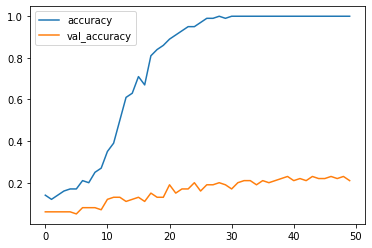

In [74]:
# Plot training and testing curves

import pandas as pd

df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])

In [75]:
# Inspect the checkpoint directory
!ls -lh model_checkpoints_best/


total 184K
-rw-r--r-- 1 root root   77 Jun 14 17:13 checkpoint
-rw-r--r-- 1 root root 174K Jun 14 17:13 checkpoint.data-00000-of-00001
-rw-r--r-- 1 root root 2.0K Jun 14 17:13 checkpoint.index


In [76]:
# Cre_ate a new model with the saved weights
new_model = get_new_model()
new_model.load_weights(checkpoint_best_path)
get_test_accuracy(new_model, x_test, y_test)


accuracy: 0.230


#### Clear directory

In [77]:
! rm -r model_checkpoints_5000 model_checkpoints_best

***
<a id="coding_tutorial_3"></a>
## Saving the entire model

#### Create checkpoint that saves whole model, not just weights

In [78]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [79]:
# Import the CIFAR-10 dataset and rescale the pixel values

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Use smaller subset -- speeds things up
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:1000]
y_test = y_test[:1000]

In [80]:
x_train.shape

(10000, 32, 32, 3)

In [81]:
!rm -r model_checkpoints

rm: cannot remove 'model_checkpoints': No such file or directory


In [82]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(checkpoint_path, save_weights_only=False,
                             frequency='epoch',
                             verbose=1)


In [83]:
# Create and fit model with checkpoint

model = get_new_model()
model.fit(x_train, y_train, epochs=3, callbacks=[checkpoint], batch_size=5)

Epoch 1/3
1995/2000 [============================>.] - ETA: 0s - loss: 1.8020 - accuracy: 0.3361
Epoch 1: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
2000/2000 [==============================] - 7s 3ms/step - loss: 1.8014 - accuracy: 0.3366
Epoch 2/3
1987/2000 [============================>.] - ETA: 0s - loss: 1.4838 - accuracy: 0.4675
Epoch 2: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
2000/2000 [==============================] - 6s 3ms/step - loss: 1.4843 - accuracy: 0.4676
Epoch 3/3
1991/2000 [============================>.] - ETA: 0s - loss: 1.3831 - accuracy: 0.5030
Epoch 3: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
2000/2000 [==============================] - 6s 3ms/step - loss: 1.3822 - accuracy: 0.5032


#### Inspect what the checkpoint has created

In [84]:
# Have a look at what the checkpoint creates
!ls -lh

!ls -lh model_checkpoints/

total 8.0K
drwxr-xr-x 4 root root 4.0K Jun 14 17:13 model_checkpoints
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data
total 144K
drwxr-xr-x 2 root root 4.0K Jun 14 17:13 assets
-rw-r--r-- 1 root root  14K Jun 14 17:13 keras_metadata.pb
-rw-r--r-- 1 root root 117K Jun 14 17:13 saved_model.pb
drwxr-xr-x 2 root root 4.0K Jun 14 17:13 variables


In [85]:
# Enter variables directory
!ls -lh model_checkpoints/variables/

total 184K
-rw-r--r-- 1 root root 178K Jun 14 17:13 variables.data-00000-of-00001
-rw-r--r-- 1 root root 2.2K Jun 14 17:13 variables.index


In [86]:
# Get the model's test accuracy

get_test_accuracy(model, x_test, y_test)

accuracy: 0.527


#### Create new model from scratch

In [87]:
# Delete model
del model


In [88]:
from tensorflow.keras.models import load_model

In [89]:
# Reload model from scratch

model = load_model(checkpoint_path)

get_test_accuracy(model, x_test, y_test)


accuracy: 0.527


#### Use the .h5 format to save model

In [90]:
# Save the model in .h5 format
model.save('my_model.h5')


In [91]:
# Inspect .h5 file
!ls -lh
# !ls -lh my_model.h5

total 88K
drwxr-xr-x 4 root root 4.0K Jun 14 17:13 model_checkpoints
-rw-r--r-- 1 root root  78K Jun 14 17:13 my_model.h5
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data


In [92]:
# Delete model
del model


In [93]:
# Reload model from scratch
model = load_model('my_model.h5')
get_test_accuracy(model, x_test, y_test)


accuracy: 0.527


#### Clear directory

In [94]:
! rm -r model_checkpoints
! rm my_model.h5
! ls -lh

total 4.0K
drwxr-xr-x 1 root root 4.0K Jun  1 13:50 sample_data


***
<a id="coding_tutorial_4"></a>
## Loading pre-trained Keras models

#### Import and build Keras ResNet50 model

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model using the Keras API.

In [95]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 2s 0us/step


In [110]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

#### Import and preprocess 3 sample images

In [96]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [97]:
# Import 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('water_tower.jpg', target_size=(224, 224))

#### Use ResNet50 model to classify images

In [98]:
# Useful function: presents top 5 predictions and probabilities

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...]
    x = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'],
                             index=np.arange(5)+1)
    for i in range(5):
        top_preds.loc[i+1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i+1, 'probability'] = preds[0][i][2] 
    return top_preds

##### Image 1: lemon

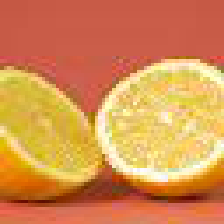

In [111]:
# Display image
lemon_img


In [104]:
# Display top 5 predictions
get_top_5_predictions(lemon_img)


49152/35363 [=========================================] - 0s 0us/step


,prediction,probability
1,consomme,0.2278
2,lemon,0.221758
3,eggnog,0.151335
4,ladle,0.040088
5,spotlight,0.029197


##### Image 2: viaduct

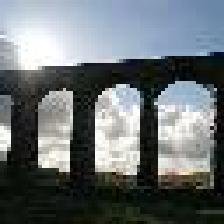

In [113]:
# Display image

viaduct_img

In [107]:
# Display top 5 predictions

get_top_5_predictions(viaduct_img)


,prediction,probability
1,vault,0.367951
2,prison,0.111742
3,viaduct,0.110738
4,window_screen,0.088231
5,fire_screen,0.020675


##### Image 3: water tower

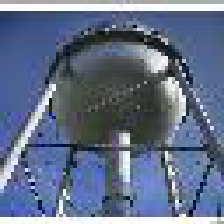

In [112]:
# Display image
water_tower_img

In [109]:
# Display top 5 predictions
get_top_5_predictions(water_tower_img)


,prediction,probability
1,solar_dish,0.384681
2,ladle,0.196179
3,planetarium,0.116682
4,strainer,0.04999
5,jigsaw_puzzle,0.021947


***
<a id="coding_tutorial_5"></a>
## Tensorflow Hub modules

#### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In the coding tutorial on Coursera, this model is loaded directly from disk. On Colab, you will load the model from TensorFlow Hub.

In [114]:
import tensorflow_hub as hub

In [121]:
# Build Google's Mobilenet v1 model

module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/5"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])

In [127]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              1343049   
                                                                 
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


#### Use MobileNet model to classify images

In [122]:
# Retrieve the image files

!wget -q -O lemon.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1JSgQ9qgi9nO9t2aGEk-zA6lzYNUT9vZJ"
!wget -q -O viaduct.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1sQzMKmyCR5Tur19lP3n1IIlEMG_o6Mct"
!wget -q -O water_tower.jpg --no-check-certificate "https://docs.google.com/uc?export=download&id=1cPAQD1O6mAiMbg0fmG5HIk8OuO_BSC6J"

In [123]:
# Import and preprocess 3 sample ImageNet images

from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img("lemon.jpg", target_size=(160, 160))
viaduct_img = load_img("viaduct.jpg", target_size=(160, 160))
water_tower_img = load_img("water_tower.jpg", target_size=(160, 160))

In [125]:
# Read in categories text file

with open('data/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [143]:
# Useful function: presents top 5 predictions

import pandas as pd

def get_top_5_predictions(img):
    x = img_to_array(img)[np.newaxis, ...] / 255.0
    preds = model.predict(x)
    print(f'predictions: {preds}')
    print(f'predictions shape: {preds.shape}')
    top_preds = pd.DataFrame(columns=['prediction', 'probability_score'],
                             index=np.arange(5)+1)
    # print(top_preds.head())
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
        top_preds.loc[i+1, 'probability_score'] = preds[0, sorted_index[i]]
            
    return top_preds

##### Image 1: lemon

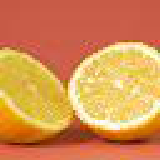

In [144]:
lemon_img

In [145]:
get_top_5_predictions(lemon_img)

predictions: [[-4.071503   -3.7900531  -0.20665698 ...  0.26492938  2.3751879
   0.84341943]]
predictions shape: (1, 1001)


,prediction,probability_score
1,shower cap,12.548315
2,tray,9.925293
3,candle,9.580334
4,brassiere,9.333363
5,African chameleon,9.193893


##### Image 2: viaduct

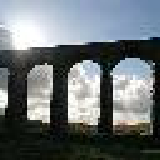

In [146]:
viaduct_img

In [147]:
get_top_5_predictions(viaduct_img)

predictions: [[-4.1152177 -1.7890841 -1.9885845 ... -1.2015544  2.3773997  3.9827712]]
predictions shape: (1, 1001)


,prediction,probability_score
1,viaduct,11.636429
2,pier,9.918017
3,dam,9.562244
4,prison,9.299345
5,solar dish,9.291434


##### Image 3: water tower

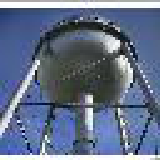

In [148]:
water_tower_img

In [149]:
get_top_5_predictions(water_tower_img)

predictions: [[-4.3445663 -2.9268005 -4.675598  ... -2.0096118 -0.9824457  1.1206927]]
predictions shape: (1, 1001)


,prediction,probability_score
1,solar dish,9.203849
2,water tower,9.039423
3,aircraft carrier,8.538888
4,jigsaw puzzle,8.328412
5,oxygen mask,8.181915
